# RL for optimal chemotherapy delivery

Based on:

1) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2767418/?fbclid=IwAR2vDuvGoxQtRluInn5UVNzLCYR3vHHn_lca4B1KIkUqRqU3a8hnC0v_UDk

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
from gym import Env, spaces
import time

import scipy.integrate as integrate
import scipy.stats as stats


!pip install stable-baselines3[extra]
from stable_baselines3 import DDPG, PPO, DQN, A2C
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.env_checker import check_env

## Data Generation

Clinical reinforcement trials:

* A finite, reasonably small set of decision times is identified
* For each decision time, a set of possible treatments (continuous or finite)
* A utility function (cost) that can be evaluated at each time point and contains a weighted combination of outcomes

Here, we are interested in the specific case of chemotherapy for cancer treatment.

The model used to simulate such a trial in Paper 1 is defined as follows:
$$\dot{W_t} = a_1(M_t \lor M_0) + b_1(D_t - d_1)$$
$$\dot{M_t} = [a_2(W_t\lor W_0) - b_2(D_t - d_2)] \times 1\{{M_t>0}\}$$

and $$W_{t+1} = W_t + \dot{W_t}$$
$$M_{t+1} = M_t + \dot{M_t}$$

with:
- $M_t$ the tumor size at time t
- $W_t$ the negative part of wellness (in response to chemotherapy and toxicity), that we will call "sadness" for simplicity. 
- $D_t$ the chemotherapy agent dose level. 

All other variables are fixed. Let us now generate data following this model (firstly using the same constant values as them, and sampling initial values from the same distributions).

In [ ]:
# values fixed in paper
a1,a2 = 0.1,0.15
b1, b2 = 1.2, 1.2
d1, d2 = 0.5,0.5
mw_max, d_max = 2,1

model_coefs = (a1,a2,b1,b2,d1,d2)

def W_dot(c,M,D):
  """
  c: model coefficients
  M: tumor size at time t
  D: dose level at time t
  """
  return c[0]*M + c[2]*(D-c[4])

def M_dot(c,W,D,M):
  """
  c: model coefficients
  W: toxicity at time t
  M: tumor size at time t
  D: dose level at time t
  """
  if M<=0: return 0 #Tumor has been cured
  return (c[1]*W - c[3]*(D-c[5]))

def generate_data(N,T,c,mw_max,d_max):
  data = []
  for i in range(N): #Generate data for N patients

    #At time 0, sample W_0 and M_0 from a uniform distribution on (0,2)
    W,M = np.random.uniform(0,mw_max),np.random.uniform(0,mw_max)
    while W==0 or M==0: W,M = np.random.uniform(0,mw_max),np.random.uniform(0,mw_max)

    #Generate initial drug level from uniform distribution (0.5,1) to account
    # for a minimum level at the beginning (0.5)
    D = np.random.uniform(0.5,d_max)

    Ws, Ms, Ds = [W],[M],[D] 
    for t in range(1,T): #Timesteps
      Ws.append(W + W_dot(c,M,D))
      Ms.append(max(0,M + M_dot(c,W,D,M)))
      
      #Generate drug level from uniform distribution (0.5,1)
      D = np.random.uniform(0,d_max)
      Ds.append(D)
      #Update W and M
      W,M = Ws[-1],Ms[-1]
    
    data.append({'W':Ws,'M':Ms,'D':Ds})
  return data

In [ ]:
#Generate data
N = 100 # number of patients to simulate
T = 12 # length of trial (in days)
data = generate_data(N,T,model_coefs,mw_max,d_max)

In [ ]:
#Plot the evolution of tumor size and wellness for a given patient
def plot_WM(data,T,patient_id):
  times = [t for t in range(T)]
  W = data[patient_id]['W']
  M = data[patient_id]['M']
  plt.plot(times,W,label="Sadness (toxicity)")
  plt.plot(times,M,label="Tumor size")
  plt.legend()
  plt.title("Evolution of wellness and tumor size through time for patient {}".format(patient_id))
  plt.xlabel("Time")
  plt.ylabel("Values")
  plt.show()

def plot_D(data,T,patient_id):
  times = [t for t in range(T)]
  D = data[patient_id]['D']
  plt.plot(times,D)
  plt.title("Random drug dosing actions for patient {}".format(patient_id))
  plt.xlabel("Time")
  plt.ylabel("Values")
  plt.show()

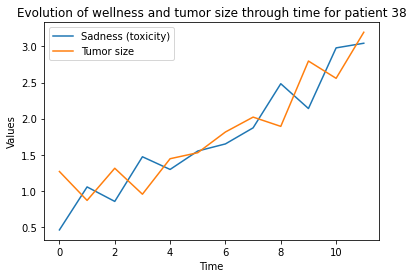

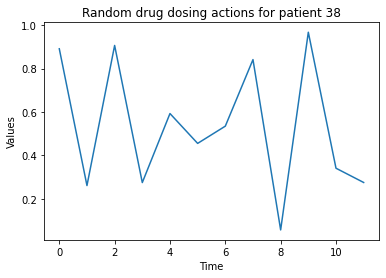

In [ ]:
patient_id = 38
plot_WM(data,T,patient_id)
plot_D(data,T,patient_id)

## OpenAI Gym framework

We now write our system as a Gym environment.

In [ ]:
def hazard(s, mu):
  """
  Hazard function
  s: state at time t,
  mu: (m0, mu1, m2) weights for influence on survival rate
  """
  mu0, mu1, mu2 = mu
  w, m = s
  l = np.exp(mu0+mu1*w + mu2*m)
  return l

def survival(s0, s1, mu, t, dt):
  """
  Survival function
  s: state at time t, 
  mu: (m0, mu1, m2) weights for influence on survival rate
  t: current time
  dt: timestep
  """
  # trapezoid integration
  delta_lambda = dt/2*(hazard(s0, mu)+hazard(s1, mu))
  # assert delta_lambda > 0
  delta_f = np.exp(-delta_lambda)
  death = stats.bernoulli.rvs(1-delta_f, size=1)
  return death

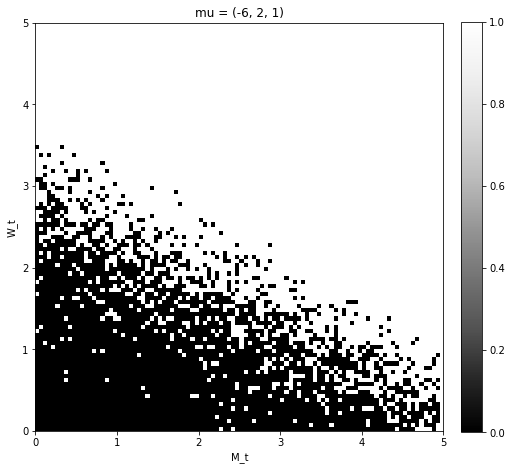

In [ ]:
N = 100
s = np.linspace(0, 5, N)
extent = [s[0], s[-1], s[-1], s[0]]
mu = (-6, 2, 1)
death_sample = np.ones((N, N))
for i in range(len(s)-1):
  for j in range(len(s)-1):
    death_sample[i][j] = survival((s[i], s[j]), (s[i+1], s[j+1]), mu, 1, 1)
    # death_sample[i][j] = hazard((s[i], s[j]), mu)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('mu = {}'.format(mu))
im = ax.imshow(death_sample/np.max(death_sample), cmap='Greys_r', extent=extent)
ax.invert_yaxis()
ax.set_xlabel('M_t')
ax.set_ylabel('W_t')
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

When W and M are high (high toxicity and tumor size), patient is very likely to die, the patient lives inversely. 

In [ ]:
#We define the reward function that has to be used when 
#defining the environment class
def R(s0, a, s1, t, dt):
  """
  s0: state at time t,
  a: action at time t,
  s1: state at time t+1
  t: time 
  dt: timestep
  """
  w0,m0 = s0
  w1,m1 = s1
  diff1=w1-w0
  diff2=m1-m0

  #R1
  mu = (-6, 2, 1) # mu selected arbitrarily using plot above
  death = survival(s0, s1, mu, t, dt)
  # death=0
  if death==1: r1=-60
  else: r1=0
  #R2
  if diff1<=-0.5: r2=5
  elif diff1>=0.5: r2=-5
  else: r2=0

  #R3
  if m1==0: r3=30
  else:
    if diff2<=-0.5: r3=5
    elif diff2>=0.5: r3=-5
    else: r3=0

  return r1+r2+r3

In [ ]:
class Trial(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}
  def __init__(self, model_coefs, T, timestep, mw_max,d_max,m_max,discretize=0):
    super(Trial, self).__init__()
    self.c = model_coefs
    self.mw_max,self.d_max,self.m_max = mw_max,d_max,m_max
    self.discretize = discretize
    #Define observation spaces
    self.observation_space = spaces.Box(low=0, high=self.m_max, shape=(2,))
    #Define action space
    if self.discretize==1: self.action_space = spaces.Discrete(self.d_max)
    else: 
      self.action_space = spaces.Box(low=0.5,high=self.d_max-0.01,shape=(1,))
    # initialize state (W, M) ~ Unif(0, 1)
    W0, M0 = np.random.uniform(0,self.mw_max), np.random.uniform(0,self.mw_max)
    while W0==0 or M0==0: W0, M0 = np.random.uniform(0,self.mw_max), np.random.uniform(0,self.mw_max)
    self.state = np.array([W0, M0]).astype(np.float32)
    # initialize time
    self.T = T
    self.dt = timestep
    self.t = 0

  def step(self, action):
    if self.discretize==1: action = action/10
    else: action = action[0]
    W_new = self.state[0] + W_dot(self.c, self.state[1], action)
    M_new = max(0,self.state[1] + 
                M_dot(self.c, self.state[0], action, self.state[1]))
    reward = R((self.state[0],self.state[1]), action, (W_new,M_new), self.t, self.dt)
    self.state = np.array([W_new, M_new]).astype(np.float32)
    self.t += self.dt
    if self.t == self.dt: #After first round doses can be lower
      self.action_space = spaces.Box(low=0.01,high=self.d_max-0.01,shape=(1,))

    #Done when patient cured (M=0) or dead (reward less than -20 means r1=-60)
    done=True if self.state[1]==0 or reward<-20 or self.t > self.T else False
    info = {}
    return self.state, reward, done, info
    
  def reset(self):
    # Reset the state of the environment to an initial state
    self.t = 0

    W0, M0 = np.random.uniform(0,self.mw_max), np.random.uniform(0,self.mw_max)
    while W0==0 or M0==0: W0, M0 = np.random.uniform(0,self.mw_max), np.random.uniform(0,self.mw_max)
    self.state = np.array([W0, M0]).astype(np.float32)

    return self.state

  def render(self, mode='human', close=False):
    # Render the environment to the screen
    print("Time t={}, Sadness (toxicity): {}, Tumor size: {}".format(self.t,
                                                  self.state[0],self.state[1]))

### Simulating the environment

Simulating and checking that the environment is [stable-baseline3](https://stable-baselines3.readthedocs.io/en/master/index.html) compatible:

In [ ]:

a1,a2 = 0.1,0.15
b1, b2 = 1.2, 1.2
d1, d2 = 0.5,0.5
mw_max, d_max = 2, 1
model_coefs = (a1,a2,b1,b2,d1,d2)
m_max = 100 #Value max for tumor size
dt = 1
T = 12

In [ ]:
#Simulate environment
env = Trial(model_coefs, T, dt, mw_max, d_max, m_max)
#T = 0
#Generate initial drug level from uniform distribution (0.5,1) to account
# for a minimum level at the beginning (0.5)

#action = np.array([np.random.uniform(0.5,d_max)]) #First action (first drug dose)
#env.render()

for t in range(T):
  env.render()
  action = env.action_space.sample()
  print("Dose: ",action[0])
  env.step(action)
  #while action==0: action = env.action_space.sample() #Make sure action is not 0
  if env.state[1]==0: 
    print("Tumor completely absorbed")
    break

check_env(env)

Time t=0, Sadness (toxicity): 1.4557992219924927, Tumor size: 1.2325655221939087
Dose:  0.62518024
Time t=1, Sadness (toxicity): 1.7292721271514893, Tumor size: 1.300719141960144
Dose:  0.15735309
Time t=2, Sadness (toxicity): 1.4481678009033203, Tumor size: 1.9712862968444824
Dose:  0.7958934
Time t=3, Sadness (toxicity): 2.000368595123291, Tumor size: 1.8334394693374634
Dose:  0.2771427
Time t=4, Sadness (toxicity): 1.9162838459014893, Tumor size: 2.400923490524292
Dose:  0.65082276
Time t=5, Sadness (toxicity): 2.3373634815216064, Tumor size: 2.5073788166046143
Dose:  0.540643
Time t=6, Sadness (toxicity): 2.6368730068206787, Tumor size: 2.8092117309570312
Dose:  0.018011523
Time t=7, Sadness (toxicity): 2.3394079208374023, Tumor size: 3.7831287384033203
Dose:  0.6959519
Time t=8, Sadness (toxicity): 2.9528629779815674, Tumor size: 3.898897647857666
Dose:  0.8464302
Time t=9, Sadness (toxicity): 3.7584688663482666, Tumor size: 3.9261109828948975
Dose:  0.69732255
Time t=10, Sadness 

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/env_checker.py:273: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


## Training the Model

In [ ]:
%load_ext tensorboard

###Algorithms tried

* DQN
* PPO
* DDPG
* A2C

In [ ]:
log_path = os.path.join("training", "logs")
if not os.path.exists(log_path):
  os.makedirs(log_path)
  
import tensorflow as tf
%tensorboard --logdir './training/logs'

In [ ]:
env = Trial(model_coefs, T, dt, mw_max, d_max, m_max,1)
model1 = DQN('MlpPolicy', env, verbose=1, device='auto', tensorboard_log=log_path)
model1.learn(total_timesteps=200000, tb_log_name='run')

In [ ]:
env = Trial(model_coefs, T, dt, mw_max, d_max, m_max)
model2 = PPO('MlpPolicy', env, verbose=1, device='auto', tensorboard_log=log_path)
model2.learn(total_timesteps=200000, tb_log_name='run') #200k

In [ ]:
env = Trial(model_coefs, T, dt, mw_max, d_max, m_max)
model3 = DDPG('MlpPolicy', env, verbose=1, device='auto', tensorboard_log=log_path)
model3.learn(total_timesteps=30000, tb_log_name='run')

In [ ]:
env = Trial(model_coefs, T, dt, mw_max, d_max, m_max)
model4 = A2C('MlpPolicy', env, verbose=1, device='auto', tensorboard_log=log_path)
model4.learn(total_timesteps=100000, tb_log_name='run')

In [ ]:
model1.save("dqn100k")
model2.save("ppo200k")
model3.save("ddpg30k")
model4.save("a2c30k")

### Load and analyze models

In [ ]:
env = Trial(model_coefs, T, dt, mw_max, d_max, m_max)
env_discrete = Trial(model_coefs, T, dt, mw_max, d_max, m_max, discretize=1)

In [ ]:
''' model1 = DQN.load("dqn100k",env=env_discrete)
model2 = PPO.load("ppo200k", env=env)
model3 = DDPG.load("ddpg30k", env=env)
model4 = A2C.load("a2c30k", env=env) '''

In [ ]:
X,Y = np.mgrid[0:3:0.05, 0:3:0.05]
xy = np.vstack((X.flatten(), Y.flatten())).T
z1 = model1.predict(xy)
z2 = model2.predict(xy)
z3 = model3.predict(xy)
z4 = model4.predict(xy)

In [ ]:
obs = np.array([3,3])
model2.predict(obs)

(array([0.5], dtype=float32), None)

In [ ]:
N = z2[0].shape[0]
z1 = z1[0].T.reshape(N,)
z2 = z2[0].T.reshape(N,)
z3 = z3[0].T.reshape(N,)
z4 = z4[0].T.reshape(N,)

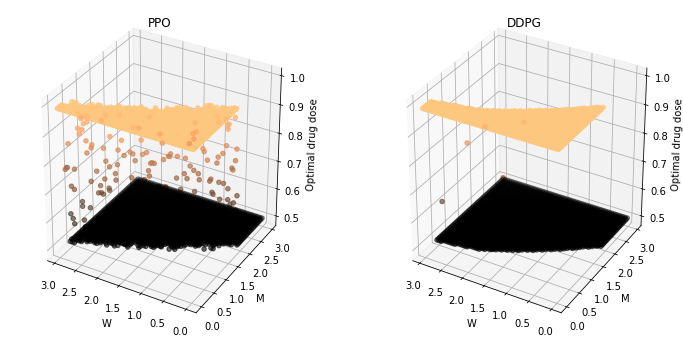

In [ ]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(X, Y, z2, c = z2, cmap='copper')
ax.set_zlabel("Optimal drug dose")
ax.invert_yaxis()

plt.xlabel("W")
plt.ylabel("M")
plt.title("PPO")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X, Y, z3, c=z3, cmap='copper')
ax.set_zlabel("Optimal drug dose")
ax.invert_yaxis()
plt.xlabel("W")
plt.ylabel("M")
plt.title("DDPG")



#plt.tight_layout()
plt.show()